In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

import numpy as np 
import jVMC
import jax.numpy as jnp
import jax.random as jrnd
import jax
import matplotlib.pyplot as plt
from tqdm import tqdm
import optax
import h5py as h5
import time
import sys
import math
from functools import partial
import bohnasa

# %%
jax.devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

In [2]:
L = 100 #int(sys.argv[1])
N = L
ldim = 20+1

numSamp = np.min([2**8, math.comb(N+L-1,L-1)-3])
print(numSamp)

homFock = jnp.ones((1,1,L),dtype=int)
oneSiteFockStates = jnp.expand_dims(jnp.eye(L,dtype=int)*N,0)
J = 1
U = 1
#0.25

seedMu = 100
folder = "data/"
name = f"obc_N{N}_L{L}_ldim{ldim}_J{J:.3f}_U{U:.3f}_numSam{numSamp}"

keyMu = jrnd.PRNGKey(seedMu)
mu = 0.* jnp.flip(-0.12*jrnd.normal(keyMu,(L,)))
H = jVMC.operator.bosons.BoseHubbard_Hamiltonian1D(L,J,U,mu=mu,lDim=ldim,)



256


In [3]:
parameterGPT= {
            "L": L,
            "LocalHilDim": ldim,
            "embeddingDim": 8,
            "depth" : 2,
            "nHeads" : 2,
            "hiddenDim": 8,
}
parameterGPT_patched= {
            "L": L,
            "LHilDim": ldim,
            "embeddingDim": 8,
            "depth" : 2,
            "patch_size" : 2,
            "nHeads" : 2,
            "hiddenDim": 8,
}


In [4]:
if math.comb(N+L-1,L-1)<1e4:
    fock = bohnasa.fockStates_fixed_particle_number(N,L)
    print("fock")
    hopping = bohnasa.hopping(fock,connections='pbc')
    hopping.matrix *= -J
    interaction = bohnasa.interaction(fock)
    interaction.matrix *= U/2
    chemical = bohnasa.chemical_mu(fock,np.array(mu))

    H_ed = hopping + interaction + chemical
    print("sdfsf")
    ev, es = np.linalg.eigh(H_ed.matrix.todense())
    print(ev[0])
    maxOv = np.argmax(np.abs(es[:,0]))
    fock.fockArray[maxOv], es[maxOv,0]
else:
    ev = np.array([np.nan,np.nan])
    es = np.array([ev]*len(ev))
print(ev,es.shape)

[nan nan] (2, 2)


In [5]:
seed = 1
batSize = numSamp


key = jrnd.PRNGKey(seed)
nS = 2**9

diagonalShift = 1e-4
diagonalMulti = 1e-4


training_steps= 2500

windowADAM = np.zeros(training_steps,dtype=bool)

windowADAM[:1200] = True


interval_hist = 100
repeats_hist = 4


In [6]:

#netGPT_annealing = jVMC.nets.bosons.GPT(**parameterGPT)
#netGPT = jVMC.nets.bosons.GPT(**parameterGPT)

netGPT_annealing = jVMC.nets.bosons.GPT_patched(**parameterGPT_patched)

par_netGPT_annealing = jVMC.nets.particle_conservation_patched(netGPT_annealing,N)

#par_netGPT_annealing = jVMC.nets.particle_conservation(netGPT_annealing,N)

#sym= jVMC.util.symmetries.get_orbit_1D(L,"reflection","translation")
#sym_par_netGPT_annealing = jVMC.nets.sym_wrapper.SymNet(sym,par_netGPT_annealing,avgFun=jVMC.nets.sym_wrapper.avgFun_Coefficients_Sep_real)
#psi_sym_par_netGPT_annealing = jVMC.vqs.NQS(sym_par_netGPT_annealing,batchSize=batSize)

psi_sym_par_netGPT_annealing = jVMC.vqs.NQS(par_netGPT_annealing,batchSize=batSize)
sampler_GPT_annealing = jVMC.sampler.MCSampler(psi_sym_par_netGPT_annealing,(L,),key,numSamples=nS)

resTrainingGPT_annealing = np.zeros((training_steps,5))
minSR_equationGPT_annealing = jVMC.util.MinSR(sampler_GPT_annealing, makeReal='real',diagonalShift=diagonalShift,diagonalMulti=diagonalMulti)


In [7]:
netGPT = jVMC.nets.bosons.GPT_patched(**parameterGPT_patched)
par_netGPT = jVMC.nets.particle_conservation_patched(netGPT,N)
#par_netGPT = jVMC.nets.particle_conservation(netGPT,N)


#sym= jVMC.util.symmetries.get_orbit_1D(L,"reflection","translation")
#sym_par_netGPT = jVMC.nets.sym_wrapper.SymNet(sym,par_netGPT,avgFun=jVMC.nets.sym_wrapper.avgFun_Coefficients_Sep_real)

#psi_sym_par_netGPT = jVMC.vqs.NQS(sym_par_netGPT,batchSize=batSize)

psi_sym_par_netGPT = jVMC.vqs.NQS(par_netGPT,batchSize=batSize)
sampler_GPT = jVMC.sampler.MCSampler(psi_sym_par_netGPT,(L,),key,numSamples=nS)

resTrainingGPT = np.zeros((training_steps,5))
minSR_equationGPT = jVMC.util.MinSR(sampler_GPT, makeReal='real',diagonalShift=diagonalShift,diagonalMulti=diagonalMulti)


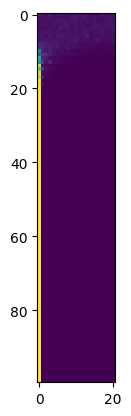

In [8]:
s,log_psi,p = sampler_GPT.sample()
histo = jVMC.util.sampling_histogram(sampler_GPT,ldim,numSamp=2**10,repeats=10)
plt.imshow(histo)

In [9]:
%%timeit
sampler_GPT.sample()

402 ms ± 436 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:

%%timeit
sampler_GPT_annealing.sample()

385 ms ± 47.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Array(11.76724968, dtype=float64, weak_type=True)

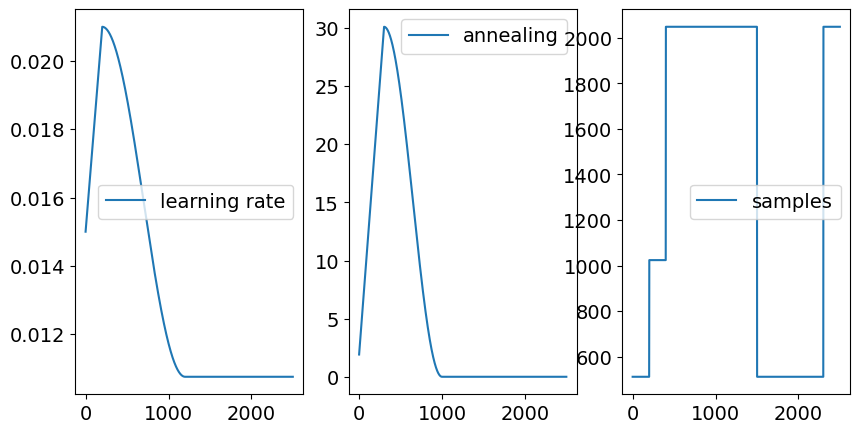

In [47]:
#tempAnnealing = optax.exponential_decay(init_value=30.5,decay_rate=0.7151, transition_steps=100,transition_begin=100)
tempAnnealing = optax.warmup_cosine_decay_schedule(1.915,30.1,warmup_steps=300,decay_steps=1000,end_value=0.00050152)
sch_numS = lambda i: int(optax.piecewise_constant_schedule(2**9,{200: 2, 400: 2, 1500: 0.25, 2300: 4})(i))

#lr_ADAM = optax.linear_schedule(init_value=0.02, end_value=0.001, transition_steps=100)
#lr_ADAM = optax.linear_schedule(init_value=0.02, end_value=0.001, transition_steps=100)
#lr_ADAM = optax.cosine_onecycle_schedule(training_steps, peak_value=.1, pct_start = 0.01, div_factor = 25.0, final_div_factor = 10000.0)
lr_ADAM = optax.warmup_cosine_decay_schedule(0.015,0.021,warmup_steps=200,decay_steps=1200,end_value=0.010752)
#plt.plot([lr_ADAM(i) for i in range(training_steps)])
fig,ax = plt.subplots(1,3,figsize=(10,5))
ax[0].plot(lr_ADAM(np.arange(training_steps)),label="learning rate")
ax[0].legend()
ax[1].plot(tempAnnealing(np.arange(training_steps)),label="annealing")
#lr_ADAM(training_steps)
ax[1].legend()
ax[2].plot([sch_numS(i) for i in np.arange(training_steps)],label="samples")
ax[2].legend()

tempAnnealing(699)

In [12]:

optimizer = optax.noisy_sgd
opt_hyp = optax.inject_hyperparams(optimizer)(learning_rate=lr_ADAM,eta=0.13,gamma=0.1)
optimizer = optax.adamw
opt_hyp = optax.inject_hyperparams(optimizer)(learning_rate=lr_ADAM)

stateOpt_GPT = opt_hyp.init(psi_sym_par_netGPT.get_parameters()) 

renormalisation = None

In [13]:
pbar = tqdm(range(training_steps))

histogramms = []
for n,p in enumerate(pbar):
    if windowADAM[n]:
        pbar.set_description("adam training")
    else:
        pbar.set_description("SR training")

    ticGPT = time.perf_counter()
    sampler_GPT.numSamples = sch_numS(n)
    if windowADAM[n]:
        Emean,Evar,stateOpt_GPT,n_p,n_p_grad, success = jVMC.util.update_optax(psi_sym_par_netGPT,sampler_GPT,H,stateOpt_GPT,opt_hyp,tempAnnealing=0,renormalization=renormalisation)
    else:
        Emean,Evar,n_p,n_p_grad,success  = jVMC.util.sr_update(psi_sym_par_netGPT,lr_ADAM(n),minSR_equationGPT,H,renormalization=renormalisation)
    tocGPT = time.perf_counter()

    resTrainingGPT[n] = [Emean,Evar,n_p,n_p_grad,tocGPT-ticGPT]
    if n%interval_hist==0:
        histogramms += [jVMC.util.sampling_histogram(sampler_GPT,ldim,numSamp=sampler_GPT.numSamples,repeats=repeats_hist)]

    postfix = {"E_GPT": resTrainingGPT[n,0], 
               "var E_GPT": resTrainingGPT[n,1], 
               }
    pbar.set_postfix(postfix)
    


SR training: 100%|██████████| 2500/2500 [1:42:55<00:00,  2.47s/it, E_GPT=-153, var E_GPT=0.0973]   


In [14]:

#optimizer = optax.noisy_sgd
#opt_hyp = optax.inject_hyperparams(optimizer)(learning_rate=lr_ADAM,eta=0.13,gamma=0.1)
stateOpt_GPT_annealing = opt_hyp.init(psi_sym_par_netGPT_annealing.get_parameters()) 

renormalisation = None

In [15]:
pbar = tqdm(range(training_steps))
histogramms_annealing = []
for n,p in enumerate(pbar):
    if windowADAM[n]:
        pbar.set_description("adam training")
    else:
        pbar.set_description("SR training")
    sampler_GPT_annealing.numSamples = sch_numS(n)

    ticGPT = time.perf_counter()
    if windowADAM[n]:
        Emean,Evar,stateOpt_GPT_annealing,n_p,n_p_grad, success = jVMC.util.update_optax(psi_sym_par_netGPT_annealing,sampler_GPT_annealing,H,stateOpt_GPT_annealing,opt_hyp,tempAnnealing=tempAnnealing(n),renormalization=renormalisation)
    else:
        Emean,Evar,n_p,n_p_grad,success  = jVMC.util.sr_update(psi_sym_par_netGPT_annealing,lr_ADAM(n),minSR_equationGPT_annealing,H,renormalization=renormalisation)
    tocGPT = time.perf_counter()

    resTrainingGPT_annealing[n] = [Emean,Evar,n_p,n_p_grad,tocGPT-ticGPT]
    if n%interval_hist==0:
        histogramms_annealing += [jVMC.util.sampling_histogram(sampler_GPT_annealing,ldim,numSamp=sampler_GPT.numSamples,repeats=repeats_hist)]

    postfix = {"E_GPT": resTrainingGPT_annealing[n,0], 
               "var E_GPT": resTrainingGPT_annealing[n,1], 
               }
    pbar.set_postfix(postfix)

SR training: 100%|██████████| 2500/2500 [1:38:30<00:00,  2.36s/it, E_GPT=-163, var E_GPT=0.308]    


parameters GPT: 10059
parameters GPT patched: 10059


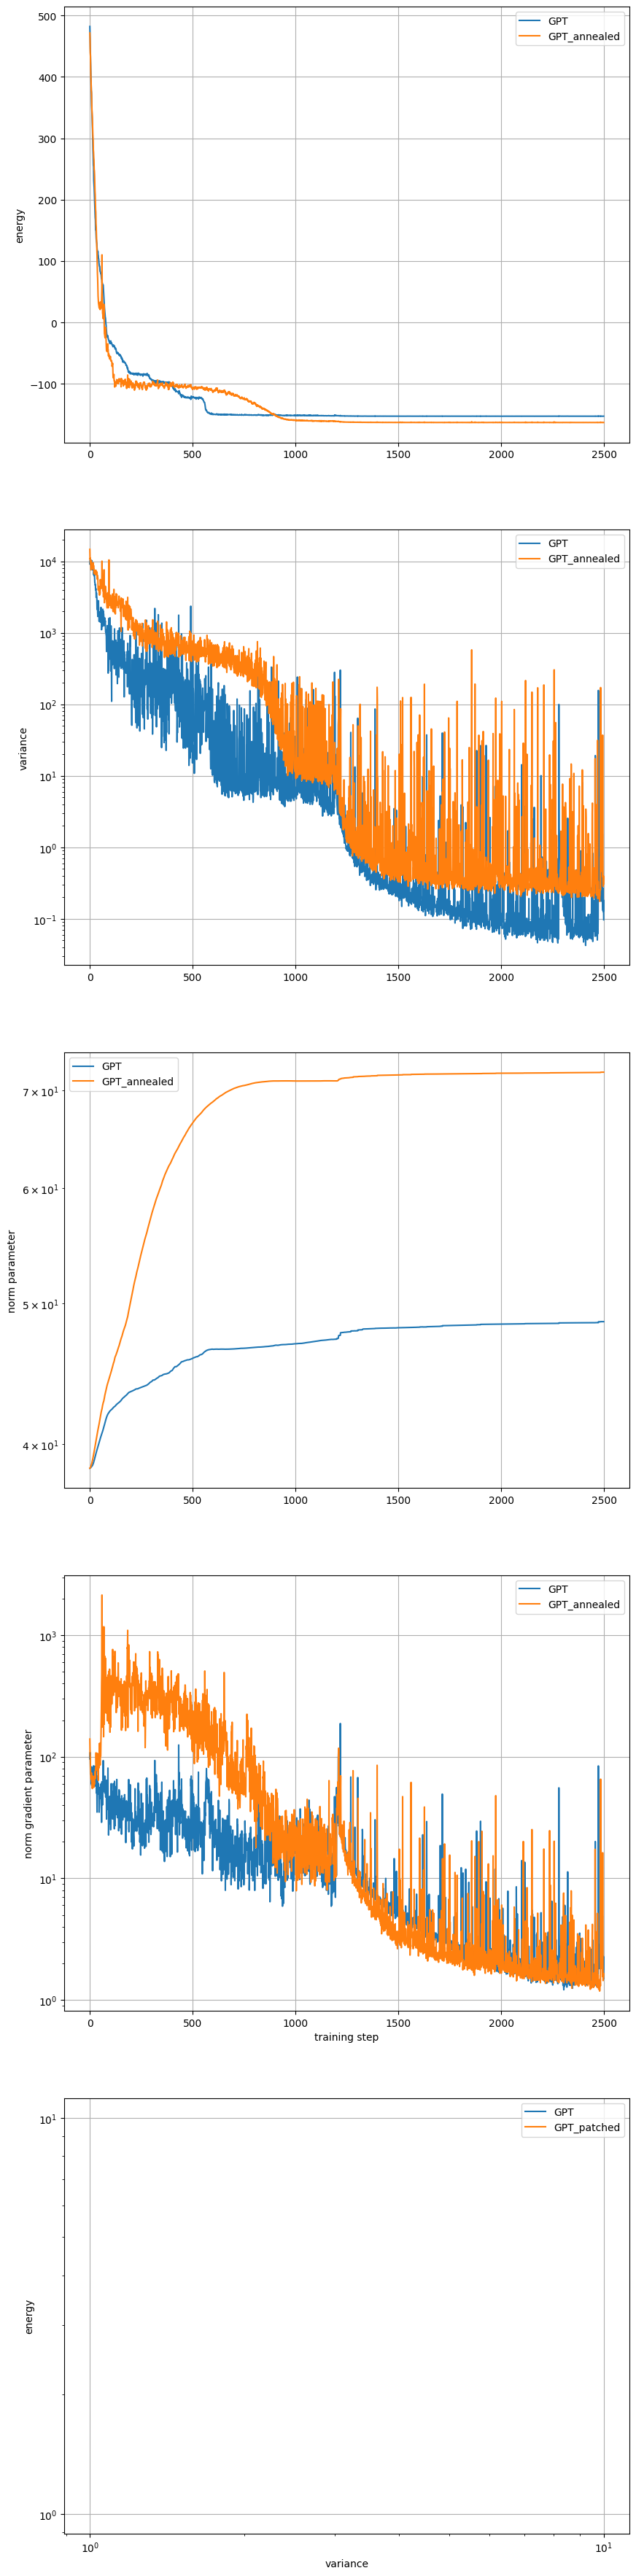

In [16]:
# %%
fig,ax = plt.subplots(5,figsize=(10,45))
ax[0].plot(resTrainingGPT[:,0],label="GPT")
ax[0].plot(resTrainingGPT_annealing[:,0],label="GPT_annealed")
ax[0].set_ylabel("energy")
ax[0].legend()
ax[0].grid()
ax[1].plot(resTrainingGPT[:,1],label="GPT")
ax[1].semilogy(resTrainingGPT_annealing[:,1],label="GPT_annealed")
ax[1].set_ylabel("variance")
ax[1].legend()
ax[1].grid()
ax[2].plot(resTrainingGPT[:,2],label="GPT")
ax[2].semilogy(resTrainingGPT_annealing[:,2],label="GPT_annealed")
ax[2].set_ylabel("norm parameter")
ax[2].grid()
ax[2].legend()
ax[3].plot(resTrainingGPT[:,3],label="GPT")
ax[3].semilogy(resTrainingGPT_annealing[:,3],label="GPT_annealed")
ax[3].set_xlabel("training step")
ax[3].grid()
ax[3].set_ylabel("norm gradient parameter")

ax[3].legend()

emin = ev[0]
ax[4].loglog(resTrainingGPT[:,1],np.abs(emin-resTrainingGPT[:,0]),label="GPT")
ax[4].loglog(resTrainingGPT_annealing[:,1],np.abs(emin-resTrainingGPT_annealing[:,0]),label="GPT_patched")
ax[4].legend()
ax[4].set_ylabel("energy")
ax[4].set_xlabel("variance")
ax[4].grid()

print("parameters GPT:", len(psi_sym_par_netGPT.get_parameters()))
print("parameters GPT patched:", len(psi_sym_par_netGPT_annealing.get_parameters()))

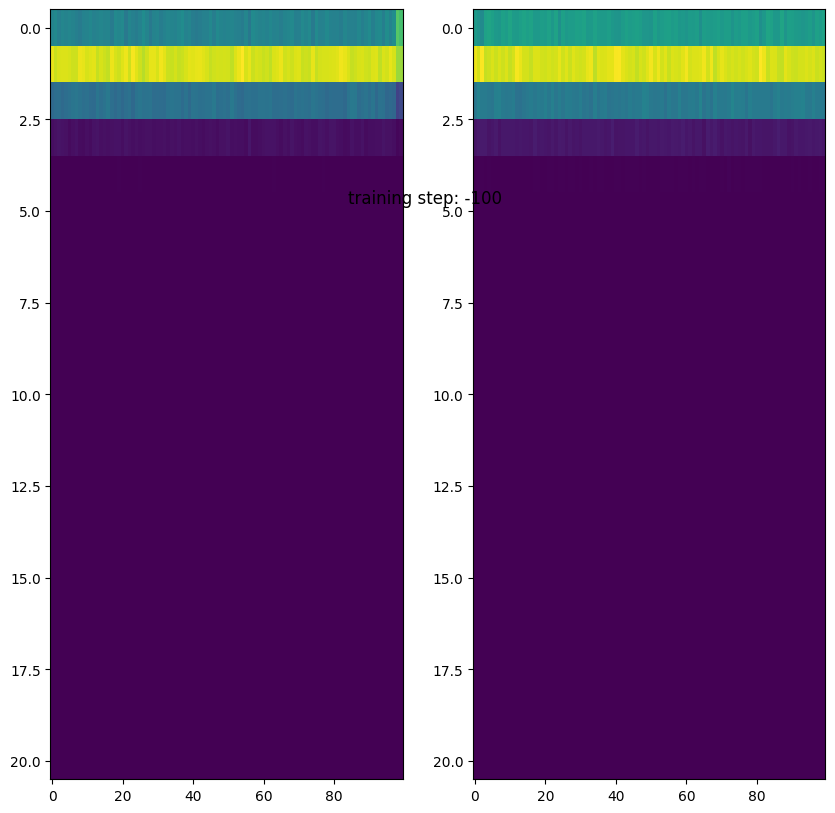

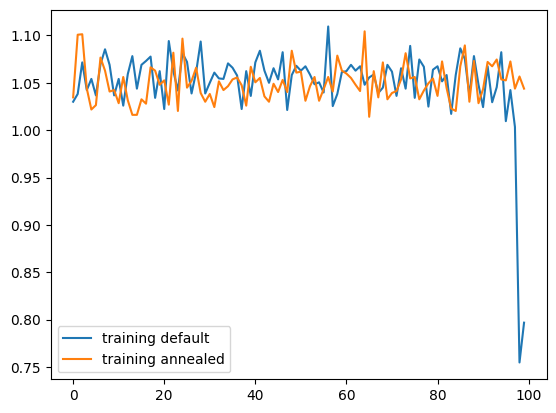

In [17]:
fig,ax = plt.subplots(1,2,figsize=(10,10))
index = -1
fig.suptitle(f"training step: {index*interval_hist}",y=0.69989)
ax[0].imshow(histogramms[index].T,aspect='auto')
ax[1].imshow(histogramms_annealing[index].T,aspect='auto')
#for i,(h,ha) in enumerate(zip(histogramms,histogramms_annealing)):
#    ax[i,0].imshow(h.T)
#    ax[i,1].imshow(ha.T)
#    #ax[i,0].set_title(f"training step {i*50}")
len(histogramms)
plt.figure()
plt.plot(np.sum(np.arange(ldim)*histogramms[index],axis=1),label="training default")#
plt.plot(np.sum(np.arange(ldim)*histogramms_annealing[index],axis=1),label="training annealed")#
plt.legend()


Text(0.5, 0.98, "net paramter: {'L': 100, 'LocalHilDim': 21, 'embeddingDim': 8, 'depth': 2, 'nHeads': 2, 'hiddenDim': 8} particles 100, no symmetries\n Bose Hubbard parameter: interaction U 1.0, hopping J 1.0, periodic boundery condition")

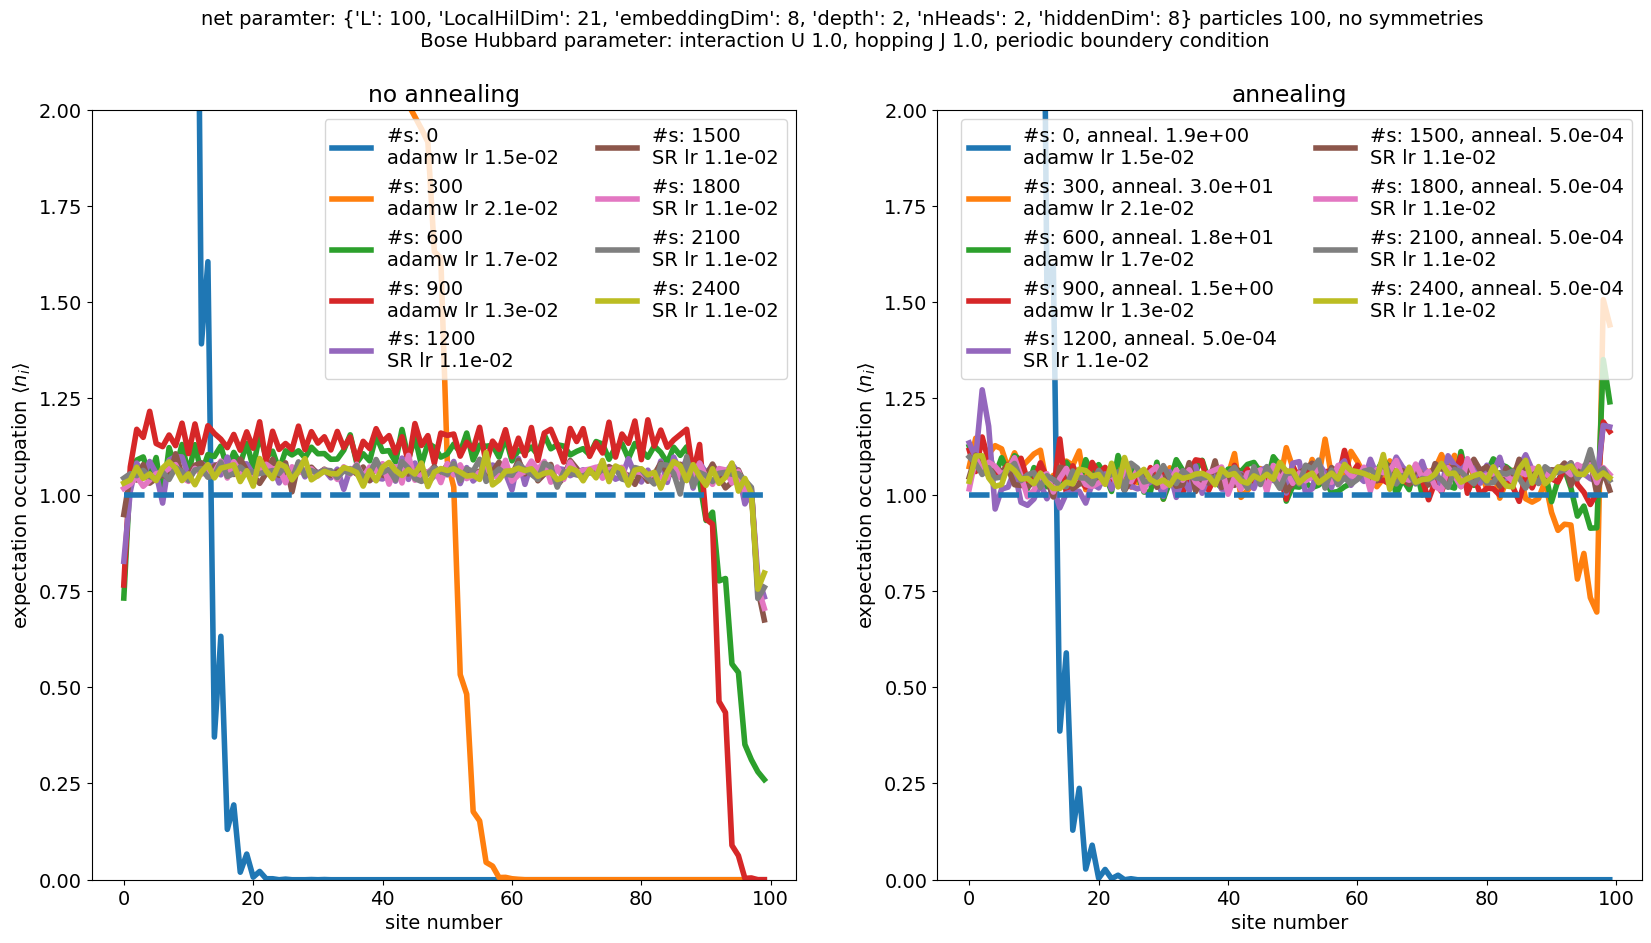

In [22]:
plt.rcParams.update({'font.size': 14})
fig,ax = plt.subplots(1,2,figsize=(20,10))
for index in range(0,training_steps//interval_hist,3):
    ax[0].plot(np.sum(np.arange(ldim)*histogramms[index],axis=1),label=f"#s: {index*interval_hist}\n"+( f"{optimizer.__name__} " if windowADAM[index*interval_hist] else "SR " ) +f"lr {lr_ADAM(index*interval_hist):.1e}",lw=4)#
ax[0].legend(ncols=2)
for index in range(0,training_steps//interval_hist,3):
    ax[1].plot(np.sum(np.arange(ldim)*histogramms_annealing[index],axis=1),label=f"#s: {index*interval_hist}, anneal. {tempAnnealing(index*interval_hist):.1e}\n"+( f"{optimizer.__name__} " if windowADAM[index*interval_hist] else "SR " ) +f"lr {lr_ADAM(index*interval_hist):.1e}",lw=4)#


ax[0].hlines(1.,0,L-1,ls="dashed",lw=4)
ax[1].hlines(1.,0,L-1,ls="dashed",lw=4)
plt.legend(ncols=2)
ax[0].set_ylim(0,2)
ax[1].set_ylim(0,2)
ax[0].set_title("no annealing")
ax[1].set_title("annealing")
ax[0].set_ylabel(r"expectation occupation $\langle n_i \rangle$")
ax[1].set_ylabel(r"expectation occupation $\langle n_i \rangle$")
ax[0].set_xlabel("site number")
ax[1].set_xlabel("site number")

fig.suptitle("net paramter: " +str(parameterGPT)+ f" particles {N}, no symmetries\n Bose Hubbard parameter: interaction U {U:.1f}, hopping J {J:.1f}, periodic boundery condition",fontsize=14 )

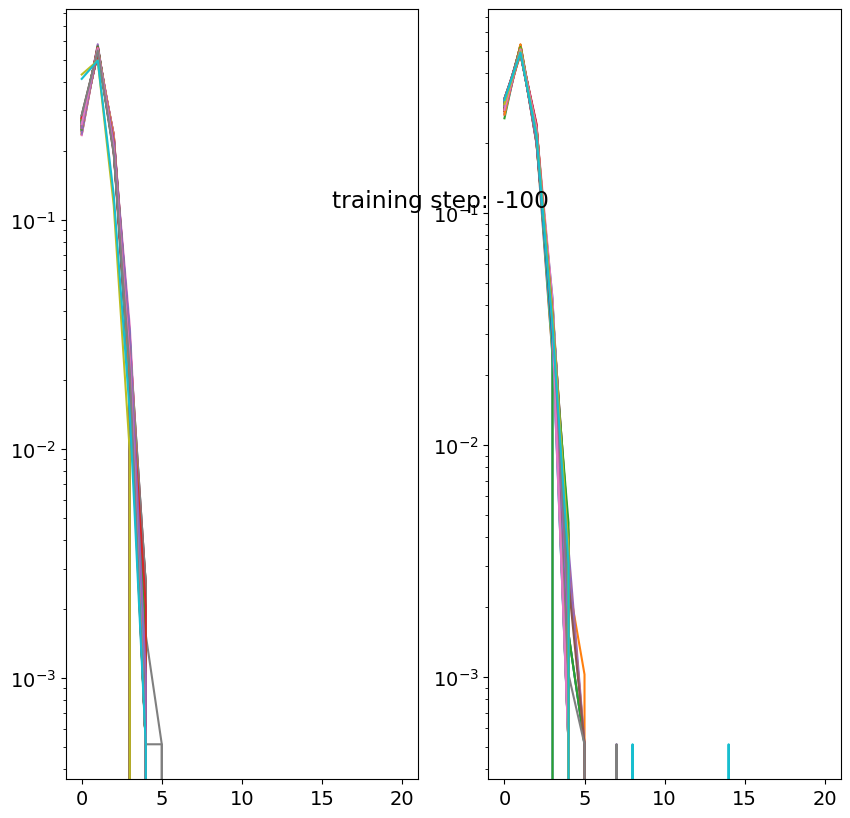

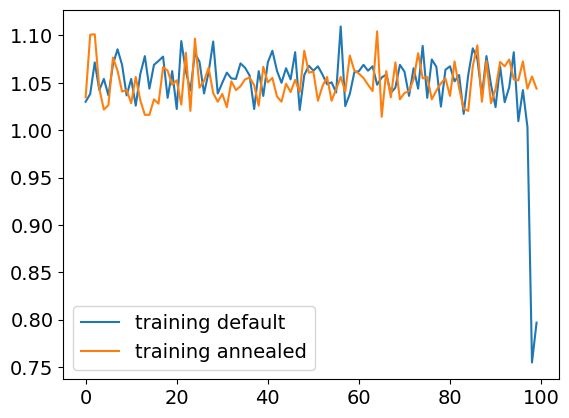

In [20]:
fig,ax = plt.subplots(1,2,figsize=(10,10))
index = -1
fig.suptitle(f"training step: {index*interval_hist}",y=0.69989)
ax[0].semilogy(histogramms[index].T)
ax[1].semilogy(histogramms_annealing[index].T)
#for i,(h,ha) in enumerate(zip(histogramms,histogramms_annealing)):
#    ax[i,0].imshow(h.T)
#    ax[i,1].imshow(ha.T)
#    #ax[i,0].set_title(f"training step {i*50}")
len(histogramms)
plt.figure()
plt.plot(np.sum(np.arange(ldim)*histogramms[index],axis=1),label="training default")#
plt.plot(np.sum(np.arange(ldim)*histogramms_annealing[index],axis=1),label="training annealed")#
plt.legend()


In [21]:
for index in range(0,training_steps//interval_hist,2):
    print(np.sum(np.arange(ldim)*histogramms[index]))#,label=f"#s: {index*interval_hist}\n"+( f"{optimizer.__name__} " if windowADAM[index*interval_hist] else "SR " ) +f"lr {lr_ADAM(index*interval_hist):.1e}",lw=4)#
for index in range(0,training_steps//interval_hist,2):
    print(np.sum(np.arange(ldim)*histogramms_annealing[index]))


105.0
105.0
105.00000000000001
105.00000000000001
105.00000000000003
105.0
105.00000000000001
105.00000000000003
105.00000000000001
105.00000000000003
105.00000000000001
105.00000000000001
105.00000000000001
105.0
105.00000000000001
105.00000000000001
105.0
105.0
105.00000000000001
105.00000000000001
105.00000000000001
105.0
105.0
105.00000000000001
105.00000000000001
105.00000000000001


In [25]:

jnp.sum(sampler_GPT_annealing.sample()[0][0],axis=1)

Array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 10

In [30]:
numSamples =2**13
jnp.sum(jnp.exp(sampler_GPT_annealing.sample(numSamples=numSamples)[1]*2))/numSamples

Array(8.72994423e-43, dtype=float64)

In [28]:
sampler_GPT_annealing.sample()

(Array([[[1, 1, 0, ..., 2, 1, 0],
         [2, 1, 0, ..., 0, 1, 2],
         [1, 3, 1, ..., 0, 2, 1],
         ...,
         [2, 1, 0, ..., 1, 1, 2],
         [1, 1, 1, ..., 1, 0, 1],
         [2, 1, 0, ..., 1, 1, 0]]], dtype=int64),
 Array([[-55.16121443, -53.18091564, -59.62242966, -53.14378745,
         -56.13142839, -55.68203573, -50.18519216, -52.79208811,
         -55.22539436, -49.95955472, -52.13107939, -53.26802928,
         -51.55009639, -55.27411583, -57.4642691 , -51.17499332,
         -55.24471254, -51.78537879, -53.00580884, -52.42312334,
         -50.96098271, -54.79044781, -56.66095566, -52.25526821,
         -53.65564728, -50.65748074, -50.55116653, -49.99587049,
         -47.98692422, -52.66561098, -53.9355691 , -52.22006247,
         -52.69118833, -54.88349154, -56.35753539, -56.7251125 ,
         -55.56046549, -48.87520715, -49.47607374, -51.50216348,
         -50.27012763, -56.68868305, -57.49905186, -54.01804813,
         -51.29635303, -51.48330797, -53.55206617, 

In [35]:
EMeanList = []
EVarList = []
numSamList = []
for iNs in tqdm(range(14)):
    Ns = 2**iNs
    numSamList += [Ns]
    psi_s, psi_logPsi, psi_p = sampler_GPT_annealing.sample(numSamples=2**12)

    Eloc = H.get_O_loc(psi_s, psi_sym_par_netGPT_annealing, psi_logPsi)
    Eso = jVMC.util.SampledObs(Eloc, psi_p)
    Emean = Eso.mean()[0]
    Evar = Eso.var()[0]
    EMeanList += [Emean]
    EVarList += [Evar]
    print("samples",Ns," energy:",Emean,"+-",Evar)

  7%|▋         | 1/14 [00:17<03:50, 17.70s/it]

samples 1  energy: (-162.85781954538592+0j) +- 0.6271215192609841


 14%|█▍        | 2/14 [00:36<03:39, 18.32s/it]

samples 2  energy: (-162.8491426075443+0j) +- 0.3678675204897036


 21%|██▏       | 3/14 [00:54<03:19, 18.13s/it]

samples 4  energy: (-162.8272718847311+0j) +- 0.6347666282266587


 29%|██▊       | 4/14 [01:12<02:59, 17.98s/it]

samples 8  energy: (-162.84683033557388+0j) +- 0.3495120756332458


 36%|███▌      | 5/14 [01:30<02:41, 17.96s/it]

samples 16  energy: (-162.83148433141793+0j) +- 4.11958739382906


 43%|████▎     | 6/14 [01:47<02:23, 17.94s/it]

samples 32  energy: (-162.8297717362003+0j) +- 0.4325167231331708


 50%|█████     | 7/14 [02:05<02:05, 17.88s/it]

samples 64  energy: (-162.85803007166052+0j) +- 0.4068458381981912


 57%|█████▋    | 8/14 [02:23<01:46, 17.83s/it]

samples 128  energy: (-162.81357811904837+0j) +- 1.6247141062585753


 64%|██████▍   | 9/14 [02:41<01:29, 17.85s/it]

samples 256  energy: (-162.83915313221607+0j) +- 0.33087997345742054


 71%|███████▏  | 10/14 [02:59<01:12, 18.11s/it]

samples 512  energy: (-162.78951070339974+0j) +- 5.904609192680892


 79%|███████▊  | 11/14 [03:17<00:53, 17.99s/it]

samples 1024  energy: (-162.85430411762567+0j) +- 0.5251297708530082


 86%|████████▌ | 12/14 [03:35<00:35, 17.85s/it]

samples 2048  energy: (-162.83533600768635+0j) +- 0.5422744560468017


 93%|█████████▎| 13/14 [03:54<00:18, 18.28s/it]

samples 4096  energy: (-162.85366182389845+0j) +- 0.34616126991050067


100%|██████████| 14/14 [04:12<00:00, 18.02s/it]

samples 8192  energy: (-162.78665996966242+0j) +- 12.392657487819314


512

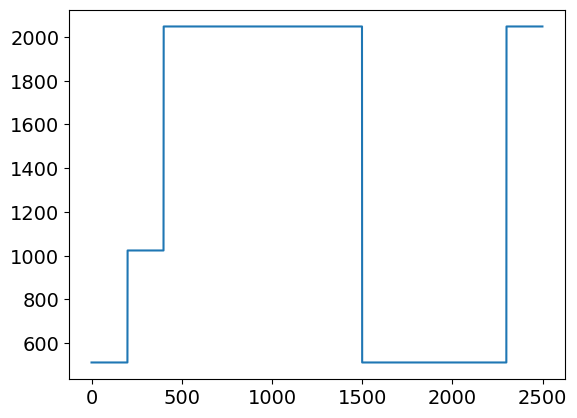

In [44]:
sampler_GPT.numSamples